# Importing libraries

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
%matplotlib inline

# Data preprocessing

## Train, valid, test

In [3]:
#proportions
print(0.77*1001)
print(0.15*1001)
print(0.08*1001)

770.77
150.15
80.08


## Batches

In [9]:
# we need the paths (relative wasn't working so absolute we go)

train_path = '/Users/mireiaguinovart/Documents/Ironhack/project_8/Project-Week-8-Final-Project/PlantVillageAUG_apples_google/train'
valid_path = '/Users/mireiaguinovart/Documents/Ironhack/project_8/Project-Week-8-Final-Project/PlantVillageAUG_apples_google/valid'
test_path = '/Users/mireiaguinovart/Documents/Ironhack/project_8/Project-Week-8-Final-Project/PlantVillageAUG_apples_google/test'

In [15]:
# we define the labels of the images

import os
labels = sorted(os.listdir('/Users/mireiaguinovart/Documents/Ironhack/project_8/Project-Week-8-Final-Project/PlantVillageAUG_apples_google/train'))[1:]
labels

['Apple_Black_rot', 'Apple_Cedar_apple_rust', 'Apple_healthy', 'Apple_scab']

In [16]:
# puting the data in the format of a Keras generator

'''Necessary to define the size of the images so they are all the same, it can be different
batch_size can be different too I guess'''

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=labels, batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=labels, batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=labels, batch_size=10, shuffle=False)

#shuffle = False for test since we need to access the unshuffled data and by default it gets shuffled

Found 3190 images belonging to 4 classes.
Found 658 images belonging to 4 classes.
Found 342 images belonging to 4 classes.


## Visualise data

In [17]:
# grab a single batch of images and labels

imgs, labels = next(train_batches)

In [18]:
# this function will plot images in the form of a grid with the 1 row and 10 columns where the images are placed
# from the tensor flow website

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

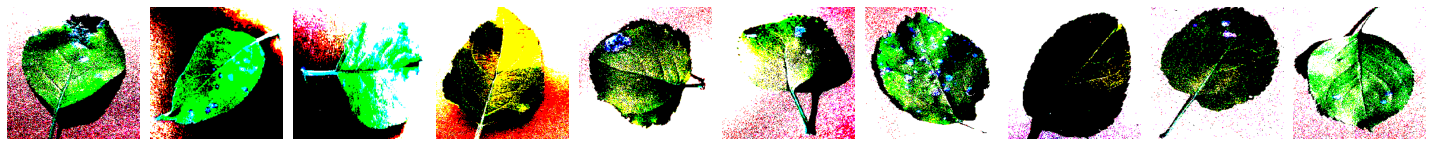

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [19]:
# it will print the BATCH
# the colours might look weird do to the preprocessing
plotImages(imgs)
print(labels)

# Model

In [20]:
# importing the model

vgg16_model = tf.keras.applications.vgg16.VGG16()

In [21]:
'''we have replicated the entire vgg16_model (excluding the output layer) 
to a new Sequential model (adding the layers one by one)'''

modelApples = Sequential()
for layer in vgg16_model.layers[:-1]:
    modelApples.add(layer)

In [22]:
# freezing the weights of what was imported from VGG16

for layer in modelApples.layers:
    layer.trainable = False

In [23]:
# we add the output layer that will identify healthy and the 3 diseases 
# (rot, scab,rust)

modelApples.add(Dense(units=4, activation='softmax'))

In [24]:
# optimise the data

modelApples.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model

In [25]:
#fitting the model to our data

modelApples.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=5,
          verbose=2
)

Train for 319 steps, validate for 66 steps
Epoch 1/5
319/319 - 1066s - loss: 0.6950 - accuracy: 0.7414 - val_loss: 0.4648 - val_accuracy: 0.8511
Epoch 2/5
319/319 - 1065s - loss: 0.3011 - accuracy: 0.9082 - val_loss: 0.3674 - val_accuracy: 0.8739
Epoch 3/5
319/319 - 1060s - loss: 0.2170 - accuracy: 0.9367 - val_loss: 0.3227 - val_accuracy: 0.8951
Epoch 4/5
319/319 - 1060s - loss: 0.1714 - accuracy: 0.9508 - val_loss: 0.3070 - val_accuracy: 0.8982
Epoch 5/5
319/319 - 1060s - loss: 0.1429 - accuracy: 0.9658 - val_loss: 0.2902 - val_accuracy: 0.8982


# Predictions + confusion matrix

In [26]:
predictions = modelApples.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [27]:
'''NOT SURE IT'LL WORK'''

# directly from scikit-learn a function to plot the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
# so we know how to pass the classes later when we want to plot it

test_batches.class_indices

{'Apple_Black_rot': 0,
 'Apple_Cedar_apple_rust': 1,
 'Apple_healthy': 2,
 'Apple_scab': 3}

Confusion matrix, without normalization
[[80  4  1  0]
 [ 1 81  1  2]
 [ 1  5 78  3]
 [ 3  1  0 81]]


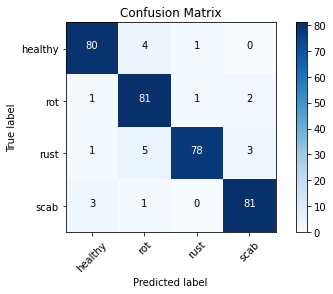

In [29]:
# we are using the confusion matrix creator function that we ran for the simpler model

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

# assigning the right labels and then plotting it

cm_plot_labels = ['healthy','rot','rust','scab']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Saving the model

In [30]:
# saving the model

modelApples.save('modelApples_google.h5')

In [28]:
# loading it back

apples_model = keras.models.load_model('Project-Week-8-Final-Project/your-project/modelApples')

## option 2

In [31]:
from tensorflow.keras.models import Sequential, save_model, load_model

In [32]:
# Save the model
filepath = 'modelApples_google'
save_model(modelApples, filepath)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: modelApples_google/assets


In [33]:
# Load the model
modelApples_google = load_model(filepath, compile = True)

In [ ]:
# both seem to work well

## Fiting again (adding epochs)

In [34]:
#fitting the model to our data

modelApples_google.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=10,
          verbose=2
)

Train for 319 steps, validate for 66 steps
Epoch 1/10
319/319 - 1100s - loss: 0.1238 - accuracy: 0.9671 - val_loss: 0.2805 - val_accuracy: 0.9043
Epoch 2/10
319/319 - 1099s - loss: 0.1008 - accuracy: 0.9746 - val_loss: 0.2718 - val_accuracy: 0.9103
Epoch 3/10
319/319 - 1097s - loss: 0.0857 - accuracy: 0.9799 - val_loss: 0.2838 - val_accuracy: 0.9103
Epoch 4/10
319/319 - 1105s - loss: 0.0761 - accuracy: 0.9806 - val_loss: 0.2709 - val_accuracy: 0.9088
Epoch 5/10
319/319 - 1104s - loss: 0.0655 - accuracy: 0.9859 - val_loss: 0.2771 - val_accuracy: 0.9103
Epoch 6/10
319/319 - 1103s - loss: 0.0582 - accuracy: 0.9881 - val_loss: 0.2593 - val_accuracy: 0.9195
Epoch 7/10
319/319 - 1101s - loss: 0.0518 - accuracy: 0.9918 - val_loss: 0.2732 - val_accuracy: 0.9088
Epoch 8/10
319/319 - 1103s - loss: 0.0457 - accuracy: 0.9915 - val_loss: 0.2724 - val_accuracy: 0.9134
Epoch 9/10
319/319 - 1107s - loss: 0.0429 - accuracy: 0.9934 - val_loss: 0.2588 - val_accuracy: 0.9179
Epoch 10/10
319/319 - 1102s - 

In [35]:
# and saving again

modelApples.save('modelApples_google2.h5')
modelApples.save('modelApples_google2')

INFO:tensorflow:Assets written to: modelApples_google2/assets
